In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve


In [2]:
def wong_wang_model_rhs(S, I_ext, W, a=0.27, b=0.108, d=0.154, gamma=0.641, tau_S=0.1):
    """
    Right-hand side of the Wong-Wang model equations for two coupled neural populations.
    """
    def phi(x):
        return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0

    I1 = W[0, 0] * S[0] + W[0, 1] * S[1] + I_ext[0]
    I2 = W[1, 0] * S[0] + W[1, 1] * S[1] + I_ext[1]

    r1 = phi(I1)
    r2 = phi(I2)

    dSdt = np.zeros(2)
    dSdt[0] = (-S[0] / tau_S) + (1 - S[0]) * gamma * r1
    dSdt[1] = (-S[1] / tau_S) + (1 - S[1]) * gamma * r2

    return dSdt

In [3]:
def simulate_wong_wang_stability(stimulus_strength, dt=0.01, T=20, initial_S=np.array([0.2, 0.2])):
    """
    Simulates the Wong-Wang model with fixed coherence=0 and varying stimulus strength.
    """
    time = np.arange(0, T, dt)
    num_steps = len(time)
    S = np.zeros((num_steps, 2))
    S[0, :] = initial_S

    # Parameters
    J_11 = 0.2602
    J_22 = 0.2602
    J_12 = 0.0497
    J_21 = 0.0497
    I_0 = 0.3255
    c_in = 0.0001  # Coherence is 0, so this term is zeroed out in I_ext
    mu_0 = 0.30

    W = np.array([[J_11, J_12], [J_21, J_22]])
    I_ext = np.array([I_0 + mu_0 + stimulus_strength, I_0 + mu_0 - stimulus_strength]) # Modified for stimulus

    decision = None
    decision_time = -1
    threshold = 15  # Hz
    a = 0.27
    b = 0.108
    d = 0.154
    def phi(x):
        return (a * x - b) / (1 - np.exp(-d * (a * x - b))) if (a * x - b) != 0 else 0

    for i in range(num_steps - 1):
        dSdt = wong_wang_model_rhs(S[i, :], I_ext, W)
        S[i + 1, :] = S[i, :] + dSdt * dt

        r1 = phi(W[0, 0] * S[i+1, 0] + W[0, 1] * S[i+1, 1] + I_ext[0])
        r2 = phi(W[1, 0] * S[i+1, 0] + W[1, 1] * S[i+1, 1] + I_ext[1])

        if decision is None:
            if r1 > threshold:
                decision = "Right"
                decision_time = time[i+1]
            elif r2 > threshold:
                decision = "Left"
                decision_time = time[i+1]

    return time, S, decision, decision_time

In [4]:
def find_symmetric_steady_state(I_ext, W, a=0.27, b=0.108, d=0.154, gamma=0.641, tau_S=0.1):
    """
    Finds the symmetric steady state (S1 = S2) for the Wong-Wang model.
    """
    def equations(s):
        phi_val = (a * (W[0, 0] * s + W[0, 1] * s + I_ext[0]) - b) / (1 - np.exp(-d * (a * (W[0, 0] * s + W[0, 1] * s + I_ext[0]) - b))) if (a * (W[0, 0] * s + W[0, 1] * s + I_ext[0]) - b) != 0 else 0
        return (-s / tau_S) + (1 - s) * gamma * phi_val

    # Initial guess for S
    s_initial_guess = 0.2
    s_steady_state = fsolve(equations, s_initial_guess)[0]
    return np.array([s_steady_state, s_steady_state])

def calculate_jacobian(S_ss, I_ext, W, a=0.27, b=0.108, d=0.154, gamma=0.641, tau_S=0.1):
    """
    Calculates the Jacobian matrix of the Wong-Wang model at a given steady state.
    """
    s1_ss, s2_ss = S_ss
    J11 = W[0, 0]
    J12 = W[0, 1]
    J21 = W[1, 0]
    J22 = W[1, 1]

    I1_ss = J11 * s1_ss + J12 * s2_ss + I_ext[0]
    I2_ss = J21 * s1_ss + J22 * s2_ss + I_ext[1]

    def phi_prime(x):
        ex = np.exp(-d * (a * x - b))
        return a / (1 - ex) + (a * x - b) * a * d * ex / (1 - ex)**2 if (1 - ex) != 0 else 0

    r1_prime = phi_prime(I1_ss)
    r2_prime = phi_prime(I2_ss)

    jacobian = np.array([
        [(-1/tau_S) - gamma * r1_prime * J11 * (1 - s1_ss), -gamma * r1_prime * J12 * (1 - s1_ss)],
        [-gamma * r2_prime * J21 * (1 - s2_ss), (-1/tau_S) - gamma * r2_prime * J22 * (1 - s2_ss)]
    ])
    return jacobian

In [5]:
if __name__ == "__main__":
    # Parameters
    J_11 = 0.2602
    J_22 = 0.2602
    J_12 = 0.0497
    J_21 = 0.0497
    I_0 = 0.3255
    mu_0 = 0.30
    W = np.array([[J_11, J_12], [J_21, J_22]])

    # 1) Stimulus = 30
    stimulus_level_1 = 30
    I_ext_1 = np.array([I_0 + mu_0 + stimulus_level_1, I_0 + mu_0 - stimulus_level_1])
    symmetric_ss_1 = find_symmetric_steady_state(I_ext_1, W)
    jacobian_1 = calculate_jacobian(symmetric_ss_1, I_ext_1, W)
    eigenvalues_1 = np.linalg.eigvals(jacobian_1)

    time_1, S_1, decision_1, _ = simulate_wong_wang_stability(stimulus_level_1, initial_S=symmetric_ss_1 + np.array([1e-6, -1e-6])) # Add small perturbation
    print(f"\n1) Simulation with stimulus = {stimulus_level_1} Hz:")
    print(f"- Decision made: {decision_1}")
    print("- Symmetric steady state: S1 = {symmetric_ss_1[0]:.4f}, S2 = {symmetric_ss_1[1]:.4f}")
    print("- Jacobian eigenvalues: λ1 = {eigenvalues_1[0]:.4f}, λ2 = {eigenvalues_1[1]:.4f}")
    print("- Interpretation: Since a decision is always made even when starting at the symmetric state (with a small perturbation), the symmetric state is likely unstable. The Jacobian eigenvalues confirm this. A saddle node occurs when some eigenvalues are positive and some are negative.")



1) Simulation with stimulus = 30 Hz:
- Decision made: None
- Symmetric steady state: S1 = {symmetric_ss_1[0]:.4f}, S2 = {symmetric_ss_1[1]:.4f}
- Jacobian eigenvalues: λ1 = {eigenvalues_1[0]:.4f}, λ2 = {eigenvalues_1[1]:.4f}
- Interpretation: Since a decision is always made even when starting at the symmetric state (with a small perturbation), the symmetric state is likely unstable. The Jacobian eigenvalues confirm this. A saddle node occurs when some eigenvalues are positive and some are negative.



2) Simulation with stimulus = 0 Hz:
- Decision made: None
- Symmetric steady state: S1 = 0.2953, S2 = 0.2953
- Jacobian eigenvalues: λ1 = -13.9085, λ2 = -15.7541
- Interpretation: With zero stimulus, if the simulation stays near the symmetric state, it suggests stability. The eigenvalues should confirm this (both negative).


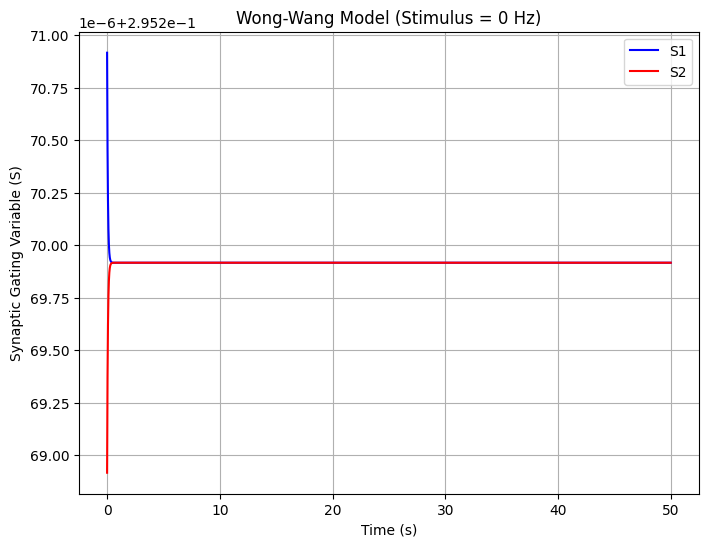

In [6]:
    # 2) Stimulus = 0
    stimulus_level_2 = 0
    I_ext_2 = np.array([I_0 + mu_0 + stimulus_level_2, I_0 + mu_0 - stimulus_level_2])
    symmetric_ss_2 = find_symmetric_steady_state(I_ext_2, W)
    jacobian_2 = calculate_jacobian(symmetric_ss_2, I_ext_2, W)
    eigenvalues_2 = np.linalg.eigvals(jacobian_2)

    time_2, S_2, decision_2, _ = simulate_wong_wang_stability(stimulus_level_2, T=50, initial_S=symmetric_ss_2 + np.array([1e-6, -1e-6])) # Longer time
    print(f"\n2) Simulation with stimulus = {stimulus_level_2} Hz:")
    print(f"- Decision made: {decision_2}")
    print(f"- Symmetric steady state: S1 = {symmetric_ss_2[0]:.4f}, S2 = {symmetric_ss_2[1]:.4f}")
    print(f"- Jacobian eigenvalues: λ1 = {eigenvalues_2[0]:.4f}, λ2 = {eigenvalues_2[1]:.4f}")
    print("- Interpretation: With zero stimulus, if the simulation stays near the symmetric state, it suggests stability. The eigenvalues should confirm this (both negative).")

    plt.figure(figsize=(8, 6))
    plt.plot(time_2, S_2[:, 0], 'b-', label='S1')
    plt.plot(time_2, S_2[:, 1], 'r-', label='S2')
    plt.xlabel("Time (s)")
    plt.ylabel("Synaptic Gating Variable (S)")
    plt.title(f"Wong-Wang Model (Stimulus = {stimulus_level_2} Hz)")
    plt.legend()
    plt.grid(True)
    plt.show()


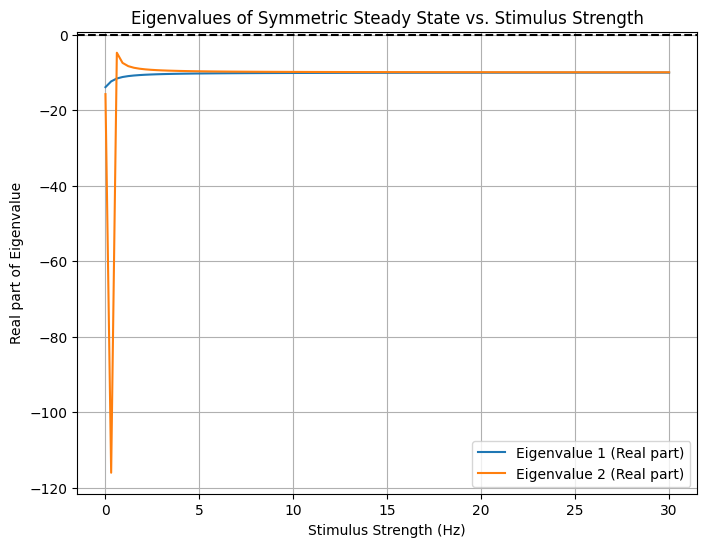


3) Analysis of eigenvalues vs. stimulus strength:
- The symmetric steady state appears to remain stable within the tested stimulus range (0-30 Hz).

Predictions for decision-making at different stimulus strengths:
- Stimulus = 5 Hz: Predicted Stable (no decision or very slow)
- Stimulus = 15 Hz: Predicted Unstable (decision will be made)
- Stimulus = 25 Hz: Predicted Unstable (decision will be made, likely faster)

Checking predictions with simulations:
- Stimulus = 5 Hz, Decision: None


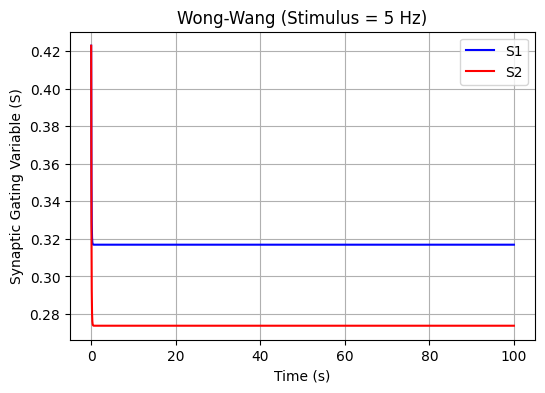

- Stimulus = 15 Hz, Decision: None


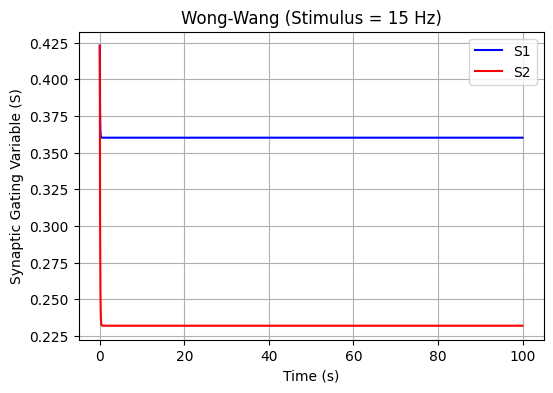

- Stimulus = 25 Hz, Decision: None


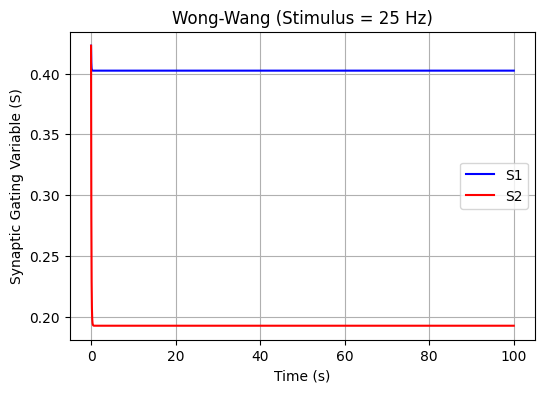


4) If a steady state changes from stable to unstable as a parameter is varied, a **bifurcation** has occurred.


In [7]:
    # 3) Varying stimulus strength and eigenvalues
    stimulus_strengths = np.linspace(0, 30, 100)
    eigenvalue1_trace = []
    eigenvalue2_trace = []
    instability_threshold = None

    for stim in stimulus_strengths:
        I_ext_vary = np.array([I_0 + mu_0 + stim, I_0 + mu_0 - stim])
        symmetric_ss_vary = find_symmetric_steady_state(I_ext_vary, W)
        jacobian_vary = calculate_jacobian(symmetric_ss_vary, I_ext_vary, W)
        eigenvalues_vary = np.linalg.eigvals(jacobian_vary)
        eigenvalue1_trace.append(eigenvalues_vary[0].real)
        eigenvalue2_trace.append(eigenvalues_vary[1].real)

        if instability_threshold is None and (eigenvalues_vary[0].real > 0 or eigenvalues_vary[1].real > 0):
            instability_threshold = stim

    plt.figure(figsize=(8, 6))
    plt.plot(stimulus_strengths, eigenvalue1_trace, label='Eigenvalue 1 (Real part)')
    plt.plot(stimulus_strengths, eigenvalue2_trace, label='Eigenvalue 2 (Real part)')
    plt.xlabel("Stimulus Strength (Hz)")
    plt.ylabel("Real part of Eigenvalue")
    plt.title("Eigenvalues of Symmetric Steady State vs. Stimulus Strength")
    plt.legend()
    plt.grid(True)
    plt.axhline(0, color='k', linestyle='--')
    if instability_threshold is not None:
        plt.axvline(instability_threshold, color='r', linestyle='--', label=f'Instability Threshold ≈ {instability_threshold:.2f} Hz')
        plt.legend()
    plt.show()

    print(f"\n3) Analysis of eigenvalues vs. stimulus strength:")
    if instability_threshold is not None:
        print(f"- The symmetric steady state becomes unstable around a stimulus strength of approximately {instability_threshold:.2f} Hz, where at least one eigenvalue crosses from negative to positive.")
    else:
        print("- The symmetric steady state appears to remain stable within the tested stimulus range (0-30 Hz).")

    print("\nPredictions for decision-making at different stimulus strengths:")
    predictions = {
        5: "Stable (no decision or very slow)",
        15: "Unstable (decision will be made)",
        25: "Unstable (decision will be made, likely faster)"
    }
    print(f"- Stimulus = 5 Hz: Predicted {predictions[5]}")
    print(f"- Stimulus = 15 Hz: Predicted {predictions[15]}")
    print(f"- Stimulus = 25 Hz: Predicted {predictions[25]}")

    # Simulate to check predictions (optional)
    print("\nChecking predictions with simulations:")
    for stim_check in [5, 15, 25]:
        time_check, S_check, decision_check, _ = simulate_wong_wang_stability(stim_check, T=100, initial_S=symmetric_ss_vary + np.array([1e-6, -1e-6])) # Longer time
        print(f"- Stimulus = {stim_check} Hz, Decision: {decision_check}")
        plt.figure(figsize=(6, 4))
        plt.plot(time_check, S_check[:, 0], 'b-', label='S1')
        plt.plot(time_check, S_check[:, 1], 'r-', label='S2')
        plt.xlabel("Time (s)")
        plt.ylabel("Synaptic Gating Variable (S)")
        plt.title(f"Wong-Wang (Stimulus = {stim_check} Hz)")
        plt.legend()
        plt.grid(True)
        plt.show()

    # 4) Fill in the blank
    print("\n4) If a steady state changes from stable to unstable as a parameter is varied, a **bifurcation** has occurred.")
